[Adapted From Udacity's Tutorial](github.com/udacity/deep-learning-v2-pytorch/)


**Neural Style Transfer** includes 3 images - style image, content image and generated image. We take style of style image, apply it to the content of content image and generate a generated image which will have the content of content image but style of the style image.

**Content** : Objects and their arrangement

**Style**: Style, Colors, Textures

![Style Transfer Example](assets/style_transfer_example.png)



To generate a generated image, we will start with an image full of noise. We will pass the noisy image through network and find out the activation after each convolution layer. Both content image and style image is also passed and their activation maps are also calculated. Then using those activation maps we find the **content error** and **style error**. The total error will be the linear combination of **content** and **style** error. Next we will change the pixel of generated image such that the total error decreases.


We will use pre-trained VGG19 Network to extract content from content image and style from style images. These pre-trained network are trained over very large datasets and for sufficient output labels. Literature have shown that they does excellent jobs of detecting [textures](https://www.robots.ox.ac.uk/~vgg/publications/2015/Cimpoi15/cimpoi15.pdf), [styles](https://arxiv.org/abs/1311.3715) and other visual processing tasks. We will freeze the parameters of these trained network so they don't get update later.

These trained neural network will give activation maps after each convolution layer. Lower level activation maps will represent pixel to pixel representation while highher level activation maps will provide high level contents, objects and their arrangement. So to find the content we must see the output from highher level activation maps.

**Overall Neural Style Transfer**
![Overall Neural Style Transfer](assets/overall_neural_style_transfer_process.png)



The main challenge here is to capture the style of style image. For that we will make a bold assumption that the activation maps produced after each convolution layer characterize the style of style image. The [idea](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) is not to use the activation map directly but producing a [Gramian Matrix](https://en.wikipedia.org/wiki/Gramian_matrix) from the activation maps.

Let's say we have an activation map of depth 6, and spatial resolution of 8x8 i.e the activation map will be the size of 6x8x8 i.e there will be 6 8x8 activation map. To create a Gram Matrix we take pairs of each activation map such that first we will take pairs of 0 and 1, 0 and 2 ... 0 and 5, then 1 and 2, 1 and 3 ... 1 and 5, then 2 and 3, 2 and 4, 2 and 5, then 3 and 4, 3 and 5, then 4 and 5. We multiply each activation map pair element wise and add them together. The added value is placed on the position according to filter count i.e if we take pair 0 and 1, then the added result is placed at postion 0 and 1 of a Gram Matrix. Also 0 and 1, and 1 and 0 will have the same value. The reason why Gram Matrix does a fantastic job of capturing style of style image is not really known and the [paper](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) also doesn't clearly mention how the author came up with this idea. One argument could be that Gram Matrix will have larger value in those position where the filters overlap. So if the Gram Matrix have larger value then the paif of filters are activated by the same inputs.


As mentioned earlier, we mostly start with white noise image but for this tutorial we will clone the content image as the generated image starter instead of white noise


In [4]:
# import resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

As we have seen in previous notebooks, Neural Network consists of two part. **Features** and **Classifier**. For this task we only need **Feautures**.

In [5]:

vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [11]:
# move the model to GPU, if available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    vgg = vgg.cuda()

vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [7]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert("RGB")
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
        
    if shape is not None:
        size = shape  # makes sure style image is resized to content image
    
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                            (0.229, 0.224, 0.225))
    ])
    
    image = in_transform(image)
    
    image = image[:3,:,:].unsqueeze(0)
    
    return image

In [22]:
# load in content and style image
content = load_image('assets/boudha.jpeg')
# Resize style to match content, makes code easier
style = load_image('assets/ben_passmore.jpg', shape=content.shape[-2:])

if train_on_gpu:
    content = content.cuda()
    style = style.cuda()

In [23]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

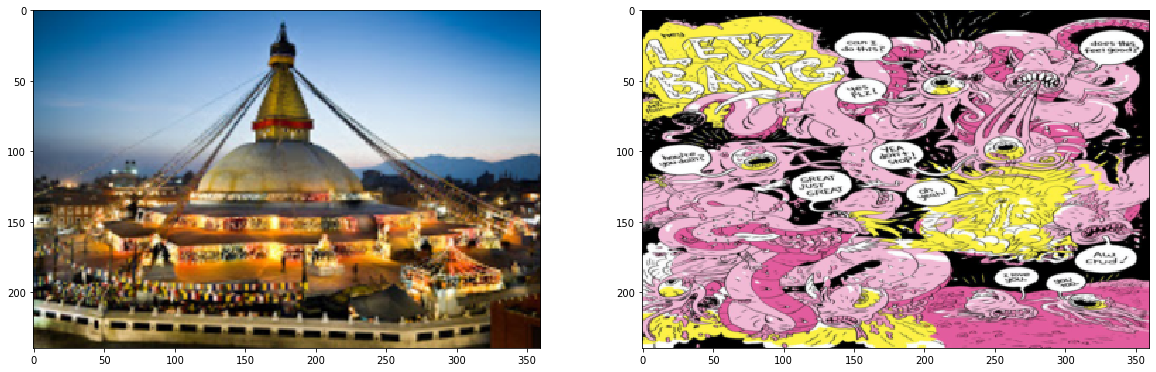

In [24]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

As discussed earlier, we get content and style from the activation maps of CNN. To do that we need to see the architecture of network we are going to use. Since we are using pre-trained VGG network. Let's see the archtiecture of VGG19.

![VGG Architecture](assets/vgg_architecture.png/)

VGG19 consist of 5 blocks of Convolution block, Let con1_1 be the first block the image pass through and conv5_1 be the fifth block the image passed through. Including max-pool and relu, the position of these 5 blocks in above trained cnn is 0, 5, 10, 19, 28. Also we will take content from position conv4_2. conv4_2 is higher enough to include higher level content invariant of position.

In [25]:
def get_features(image, model, layers=None):
    
    if layers is None:
        layers = {
            "0": "conv1_1",
            "5": "conv2_1",
            "10": "conv3_1",
            "19": "conv4_1",
            "21": "conv4_2",
            "28": "conv5_1"
        }
    features = {}
    x = image
    
    # model._modules is a dictionary holding each module in the model.
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

In [26]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

In [27]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True)

if train_on_gpu:
    target = target.cuda()

In [28]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

Total loss:  69794112.0


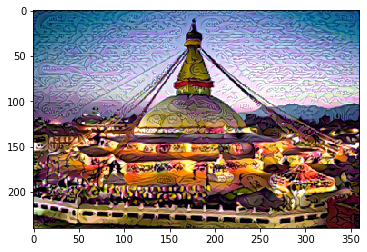

Total loss:  27360152.0


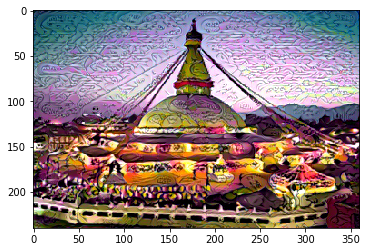

Total loss:  15484047.0


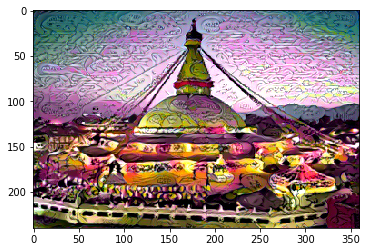

Total loss:  10229143.0


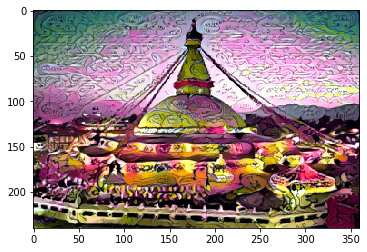

Total loss:  7369745.0


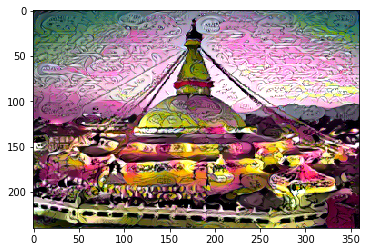

Total loss:  5596811.5


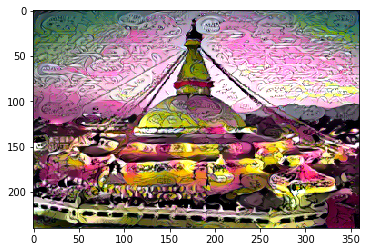

Total loss:  4413471.0


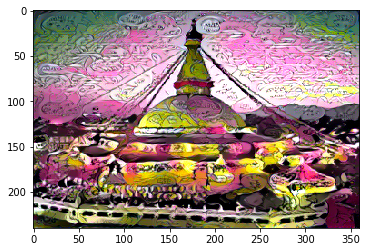

Total loss:  3569990.5


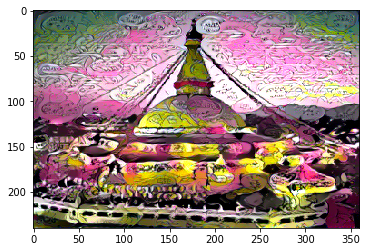

Total loss:  2943946.0


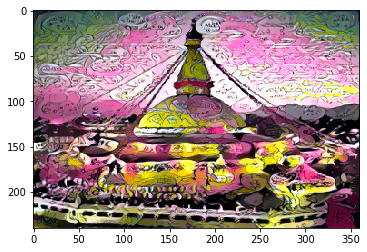

Total loss:  2463089.5


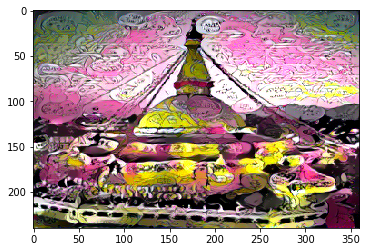

In [29]:
# for displaying the target image, intermittently
show_every = 500

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 5000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()